In [39]:
import matplotlib.pyplot as plt
from astropy.io import fits
import torch
import numpy as np
from aion.modalities import LegacySurveyImage
import h5py
from tqdm import tqdm
import umap

In [ ]:
test_file = h5py.File('../data/semi_supervised_test_i_snr_20.hdf5', 'r+')


In [3]:
im = test_file['images'][0,1:5,:,:]
im.shape

(4, 108, 108)

In [4]:
# Convert im to a torch tensor, adding a batch dimension, and sending to GPU
image_flux = torch.tensor(im.astype("float32")).unsqueeze(0).to("cuda")

# Create a typed image which keeps track of metadata
image = LegacySurveyImage(flux=image_flux, bands=["DES-G", "DES-R", "DES-I", "DES-Z"])

In [5]:
from aion.codecs import CodecManager

# Instantiate the manager
codec_manager = CodecManager(device="cuda")

# Apply a codec on our prepared image
# This will automatically download the necessary codec
tokens = codec_manager.encode(image)

In [6]:
reconstructed_image = codec_manager.decode(
    tokens,
    LegacySurveyImage,  # The modality from the 'tokens' dictionary we want to decode
    bands=["DES-G", "DES-R", "DES-I", "DES-Z"],
)  # Metadata required to reconstruct the given modality

In [10]:
rec_im = reconstructed_image.flux.detach().cpu().numpy()
rec_im.shape

(1, 4, 96, 96)

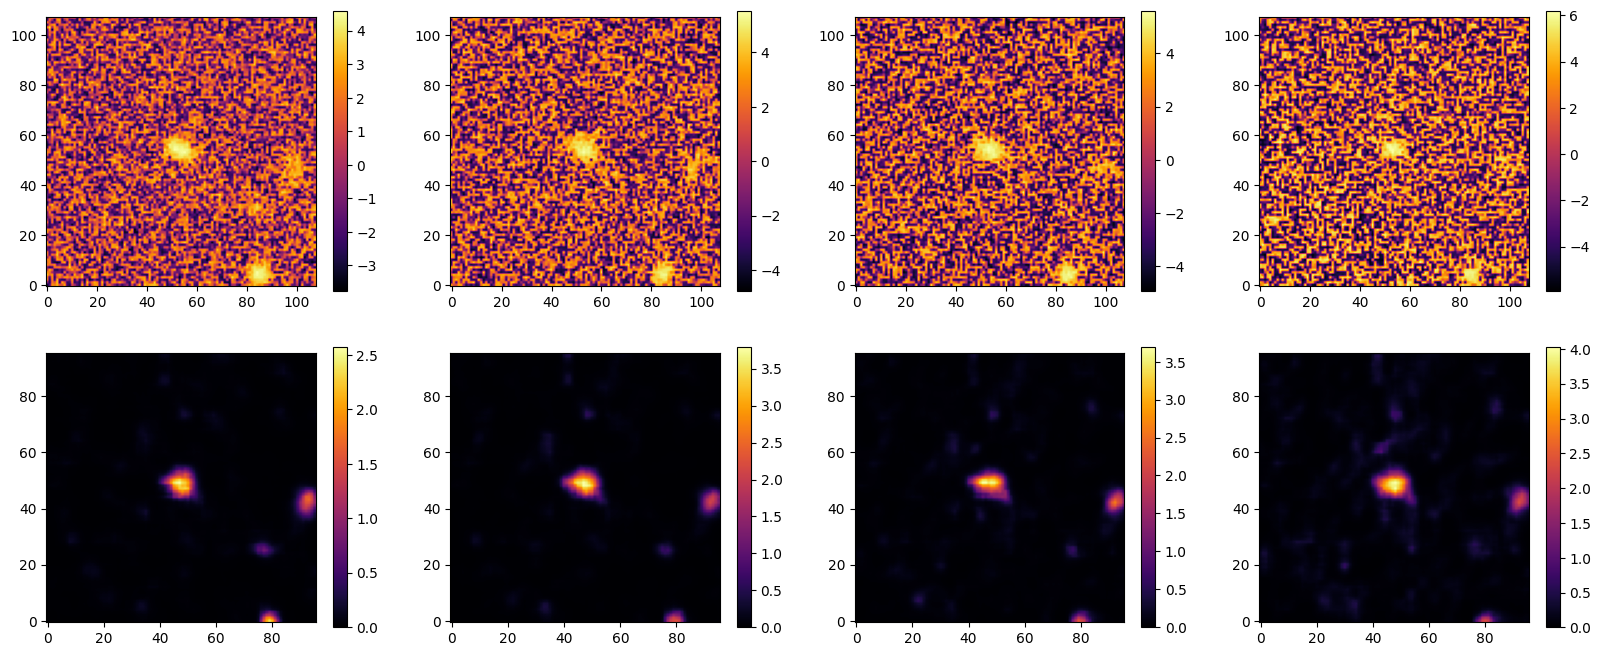

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,8))

for i in range(4):
    sd = ax[0,i].imshow(np.arcsinh(im[i,:,:]), origin='lower', cmap='inferno')
    fig.colorbar(sd, ax=ax[0,i])

    sd = ax[1,i].imshow(np.arcsinh(rec_im[0,i,:,:]), origin='lower', cmap='inferno')
    fig.colorbar(sd, ax=ax[1,i])

In [12]:
from aion.model import AION

# Disable gradients for this notebook
torch.set_grad_enabled(False)

# Importing model
model = AION.from_pretrained("polymathic-ai/aion-base").to("cuda").eval()


In [21]:
pred = model.encode(tokens, num_encoder_tokens=600)

In [27]:
ims = torch.tensor(test_file['images'][:,1:5,:,:].astype('float32')).to("cuda")
images = LegacySurveyImage(flux=ims, bands=["DES-G", "DES-R", "DES-I", "DES-Z"])

In [34]:
# Instantiate the manager
codec_manager = CodecManager(device="cuda")
batch_size = 32
n = ims.shape[0]
im_embeddings = []
for i in tqdm(range(0, n, batch_size)):
    images = LegacySurveyImage(flux=ims[i : min(n,i+batch_size)], bands=["DES-G", "DES-R", "DES-I", "DES-Z"])
    im_embeddings.append(
        model.encode(codec_manager.encode(images), num_encoder_tokens=600).mean(axis=1)
    )

100%|██████████| 89/89 [00:29<00:00,  3.02it/s]


In [35]:
im_embeddings = torch.cat(im_embeddings, dim=0).cpu().numpy()


In [40]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(im_embeddings)
embedding.shape


(2830, 2)

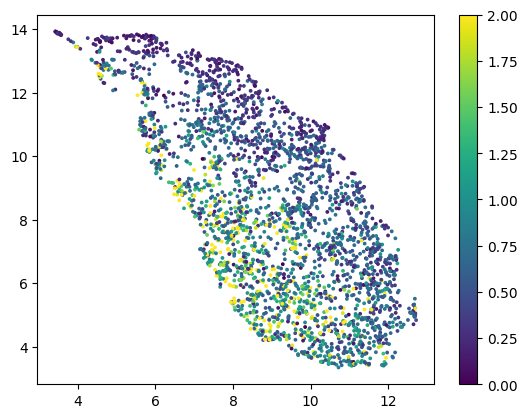

In [44]:
fig, ax = plt.subplots()

sd = ax.scatter(embedding[:,0], embedding[:,1], s=3, c=test_file['redshifts'][:], vmin=0, vmax=2)
fig.colorbar(sd, ax=ax)


In [ ]:
import numpy as np, torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import umap, math, random


In [ ]:
X = np.asarray(im_embeddings, dtype=np.float32)
y = np.asarray(test_file['redshifts'][:], dtype=np.float32)

In [ ]:
# --- Robust stratified splits with adaptive binning and index tracking ---

import numpy as np
from sklearn.model_selection import train_test_split

# --- Pre-clean: drop non-finite redshifts (and matching rows in X) ---
mask = np.isfinite(y)
if mask.sum() != len(y):
    print(f"[note] dropped {len(y)-mask.sum()} non-finite redshifts")
    X = X[mask]
    y = y[mask]

# --- Helpers ---
import numpy as np
from sklearn.model_selection import train_test_split

def z_bins(y, step=0.1, max_bin=1_000_000):
    """Uniform-width binning of redshift values y."""
    y = np.asarray(y)
    b = np.floor(y / step).astype(np.int64)
    return np.clip(b, 0, max_bin)

def make_bins_adaptive(y, test_size, init_step=0.1, grow=1.25, min_count=2, max_step=2.0):
    """
    Increase bin width multiplicatively until:
      (1) every occupied bin has at least `min_count` samples
      (2) number of classes <= number of training samples (sklearn requirement).
    Returns (bins, step_used). Uses safe min to avoid integer/inf casting issues.
    """
    y = np.asarray(y).reshape(-1)
    N = y.size
    step = init_step
    while True:
        b = z_bins(y, step=step)
        counts = np.bincount(b)
        present = counts[counts > 0]

        # safe min without 'initial', handles empty 'present'
        min_present = present.min() if present.size > 0 else np.inf
        n_classes = int(present.size)
        n_train   = int(round((1.0 - test_size) * N))

        ok_counts  = (present.size > 0) and (min_present >= min_count)
        ok_classes = (n_classes > 0) and (n_classes <= n_train)

        if ok_counts and ok_classes:
            return b, step

        if step >= max_step:
            # stop widening; caller may fall back to unstratified
            return b, step

        step *= grow


In [ ]:

rng = 42
idx_all = np.arange(len(y))

# First split
bins1, step_used = make_bins_adaptive(y, test_size=0.30, init_step=0.1)
try:
    id_tr, id_tmp, y_tr, y_tmp = train_test_split(
        idx_all, y, test_size=0.30, random_state=rng, stratify=bins1
    )
    X_tr, X_tmp = X[id_tr], X[id_tmp]
except ValueError as e:
    print(f"[note] Stratified split (train/tmp) failed -> unstratified. Reason: {e}")
    id_tr, id_tmp, y_tr, y_tmp = train_test_split(
        idx_all, y, test_size=0.30, random_state=rng, shuffle=True
    )
    X_tr, X_tmp = X[id_tr], X[id_tmp]

# Second split
bins2, _ = make_bins_adaptive(y_tmp, test_size=2/3, init_step=step_used)
try:
    id_val_tmp, id_te_tmp, y_val, y_te = train_test_split(
        np.arange(len(y_tmp)), y_tmp, test_size=2/3, random_state=rng, stratify=bins2
    )
    id_val, id_te = id_tmp[id_val_tmp], id_tmp[id_te_tmp]
    X_val, X_te = X[id_val], X[id_te]
except ValueError as e:
    print(f"[note] Stratified split (val/test) failed -> unstratified. Reason: {e}")
    id_val_tmp, id_te_tmp, y_val, y_te = train_test_split(
        np.arange(len(y_tmp)), y_tmp, test_size=2/3, random_state=rng, shuffle=True
    )
    id_val, id_te = id_tmp[id_val_tmp], id_tmp[id_te_tmp]
    X_val, X_te = X[id_val], X[id_te]

print(f"[sizes] X_tr={X_tr.shape}, X_val={X_val.shape}, X_te={X_te.shape}, step_used={step_used}")


In [ ]:
# === Standardization, model, training, MC-dropout prediction, conformal calibration, metrics ===
import numpy as np, torch, torch.nn as nn, math, random
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ----- Standardize embeddings using train statistics only -----
scaler = StandardScaler().fit(X_tr)
X_tr_s = scaler.transform(X_tr).astype(np.float32)
X_val_s = scaler.transform(X_val).astype(np.float32)
X_te_s  = scaler.transform(X_te ).astype(np.float32)

# ----- Torch datasets/loaders -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
toT = torch.from_numpy
dl_tr  = DataLoader(TensorDataset(toT(X_tr_s), toT(y_tr)), batch_size=256, shuffle=True)
dl_val = DataLoader(TensorDataset(toT(X_val_s), toT(y_val)), batch_size=512)
dl_te  = DataLoader(TensorDataset(toT(X_te_s ), toT(y_te )), batch_size=512)

In [ ]:

# ----- Heteroscedastic MLP (predicts μ and log σ²) -----
class MLPHetero(nn.Module):
    def __init__(self, d_in, widths=(512, 256), p_drop=0.1):
        super().__init__()
        layers, prev = [], d_in
        for w in widths:
            layers += [nn.Linear(prev, w), nn.GELU(), nn.Dropout(p_drop)]
            prev = w
        self.backbone = nn.Sequential(*layers)
        self.dropout  = nn.Dropout(p_drop)  # active at inference for MC-dropout
        self.mu_head     = nn.Linear(prev, 1)
        self.logvar_head = nn.Linear(prev, 1)  # outputs log(σ^2)

    def forward(self, x):
        h = self.backbone(x)
        h = self.dropout(h)
        mu     = self.mu_head(h).squeeze(-1)
        logvar = self.logvar_head(h).squeeze(-1)
        return mu, logvar

def nll_gaussian(y, mu, logvar):
    # 0.5 * [ (y-μ)^2 / σ^2 + log σ^2 ]
    return 0.5 * (torch.exp(-logvar) * (y - mu)**2 + logvar)

In [ ]:
# Re-enable autograd (earlier notebook cells may have disabled it)
import torch
torch.set_grad_enabled(True)


model = MLPHetero(d_in=X_tr_s.shape[1], widths=(512, 256), p_drop=0.1).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
# Optional sanity check
print("any(model.parameters()).requires_grad ->",
      any(p.requires_grad for p in model.parameters()))

In [ ]:
best_val, best_state = float('inf'), None
patience, bad = 25, 0

for epoch in range(500):
    model.train()
    with torch.enable_grad():  # <-- ensures grads even if a global flag lingered
        for xb, yb in dl_tr:
            xb, yb = xb.to(device), yb.to(device)
            mu, logvar = model(xb)
            loss = nll_gaussian(yb, mu, logvar).mean()
            opt.zero_grad()
            loss.backward()
            opt.step()

    # validation (no grad)
    model.eval()
    with torch.no_grad():
        val_loss_sum, n_obs = 0.0, 0
        for xb, yb in dl_val:
            xb, yb = xb.to(device), yb.to(device)
            mu, logvar = model(xb)
            val_loss_sum += nll_gaussian(yb, mu, logvar).sum().item()
            n_obs += xb.size(0)
        val_loss = val_loss_sum / max(n_obs, 1)

    if val_loss < best_val - 1e-4:
        best_val, bad = val_loss, 0
        best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
    else:
        bad += 1
        if bad >= patience:
            break

# restore best
model.load_state_dict({k: v.to(device) for k, v in best_state.items()})


In [ ]:
# === Inference, uncertainty, conformal calibration, metrics, and artifacts ===
import numpy as np, math
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- MC-dropout prediction (keeps dropout active to capture epistemic uncertainty) ---
@torch.no_grad()
def predict_mc(model, Xs: np.ndarray, T: int = 50, bs: int = 512):
    """
    Args:
        model : trained MLPHetero
        Xs    : standardized inputs, shape (N, D), np.float32
        T     : number of MC dropout samples
        bs    : batch size
    Returns:
        mu_mean      : (N,) predictive mean
        sigma_ale    : (N,) aleatoric std  (mean over MC of sqrt(exp(logvar)))
        sigma_total  : (N,) total std = sqrt( Var_MC[mu] + E_MC[exp(logvar)] )
    """
    model.train()  # activate dropout
    N = Xs.shape[0]
    mu_s   = np.zeros((T, N), dtype=np.float32)
    var_s  = np.zeros((T, N), dtype=np.float32)

    k_slices = [slice(i, min(i+bs, N)) for i in range(0, N, bs)]
    for t in range(T):
        k = 0
        for sl in k_slices:
            xb = torch.from_numpy(Xs[sl]).to(device)
            mu, logvar = model(xb)
            n = mu.shape[0]
            mu_s[t, sl]  = mu.detach().cpu().numpy()
            var_s[t, sl] = torch.exp(logvar).detach().cpu().numpy()
            k += n

    mu_mean   = mu_s.mean(axis=0)
    var_ep    = mu_s.var(axis=0, ddof=1)
    var_al_e  = var_s.mean(axis=0)
    sigma_tot = np.sqrt(var_ep + var_al_e)
    sigma_al  = np.sqrt(var_al_e)
    return mu_mean, sigma_al, sigma_tot

# --- Run MC predictions on validation and test splits ---
mu_val, sigA_val, sigT_val = predict_mc(model, X_val_s, T=50, bs=512)
mu_te,  sigA_te,  sigT_te  = predict_mc(model, X_te_s,  T=50, bs=512)

# --- Conformal calibration (scales predictive std to hit nominal coverage on val) ---
def conformal_scale(alpha: float, yv: np.ndarray, muv: np.ndarray, sigv: np.ndarray) -> float:
    r = np.abs(yv - muv) / np.maximum(sigv, 1e-8)
    return float(np.quantile(r, 1 - alpha, method="higher"))

q68 = conformal_scale(0.32, y_val, mu_val, sigT_val)
q95 = conformal_scale(0.05, y_val, mu_val, sigT_val)

lo68, hi68 = mu_te - q68 * sigT_te, mu_te + q68 * sigT_te
lo95, hi95 = mu_te - q95 * sigT_te, mu_te + q95 * sigT_te

# --- Metrics (point accuracy and interval coverage) ---
mae  = mean_absolute_error(y_te, mu_te)
rmse = math.sqrt(mean_squared_error(y_te, mu_te))
r2   = r2_score(y_te, mu_te)

# Gaussian coverage without conformal scaling (for reference)
cov68_gauss = np.mean(np.abs(y_te - mu_te) <= 1.0  * sigT_te)
cov95_gauss = np.mean(np.abs(y_te - mu_te) <= 1.96 * sigT_te)

# Conformal coverage (targeted)
cov68_conf = np.mean((y_te >= lo68) & (y_te <= hi68))
cov95_conf = np.mean((y_te >= lo95) & (y_te <= hi95))

print(
    f"Test: MAE={mae:.4f}  RMSE={rmse:.4f}  R^2={r2:.4f}  "
    f"GaussCov[68]={cov68_gauss:.3f} GaussCov[95]={cov95_gauss:.3f}  "
    f"ConfCov[68]={cov68_conf:.3f} ConfCov[95]={cov95_conf:.3f}  "
    f"(q68={q68:.3f}, q95={q95:.3f})"
)

# --- Final artifacts in memory ---
z_pred        = mu_te                # (N_test,)
sigma_total   = sigT_te              # (N_test,)
sigma_aleator = sigA_te              # (N_test,)
pi68          = (lo68, hi68)         # (N_test,), (N_test,)
pi95          = (lo95, hi95)         # (N_test,), (N_test,)

results = {
    "ids": {"train": id_tr, "val": id_val, "test": id_te},
    "y_val": y_val,
    "y_test": y_te,
    "z_pred": z_pred,
    "sigma_total": sigma_total,
    "sigma_aleator": sigma_aleator,
    "pi68": {"lo": lo68, "hi": hi68},
    "pi95": {"lo": lo95, "hi": hi95},
    "metrics": {
        "MAE": mae, "RMSE": rmse, "R2": r2,
        "GaussCov68": cov68_gauss, "GaussCov95": cov95_gauss,
        "ConfCov68": cov68_conf,  "ConfCov95": cov95_conf,
        "q68": q68, "q95": q95
    },
}

# --- Optional: quick visual diagnostics (guarded) ---
try:
    import matplotlib.pyplot as plt

    # Residual histogram
    plt.figure(figsize=(5.5,4))
    res = y_te - z_pred
    plt.hist(res, bins=40, alpha=0.8)
    plt.xlabel("Residual (z_true - z_pred)"); plt.ylabel("Count")
    plt.title("Test residuals")
    plt.tight_layout(); plt.show()

    # Uncertainty vs |residual|
    plt.figure(figsize=(5.5,4))
    plt.scatter(sigma_total, np.abs(res), s=8, alpha=0.6)
    plt.xlabel("Predicted σ_total"); plt.ylabel("|Residual|")
    plt.title("Uncertainty vs error")
    plt.tight_layout(); plt.show()

    # UMAP overlay of residuals, if a global 2-D 'embedding' and test indices exist
    if 'embedding' in globals():
        plt.figure(figsize=(6,5))
        sc = plt.scatter(embedding[id_te, 0], embedding[id_te, 1], c=res, s=6)
        plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2"); plt.title("Test residuals on UMAP")
        plt.colorbar(sc, label="z_true - z_pred")
        plt.tight_layout(); plt.show()
except Exception as _viz_err:
    print(f"[note] Skipped plots ({_viz_err})")

# --- Optional: persist arrays to disk (comment out if not desired) ---
# np.save("redshift_z_pred_test.npy", z_pred)
# np.save("redshift_sigma_total_test.npy", sigma_total)
# np.save("redshift_sigma_aleator_test.npy", sigma_aleator)
# np.save("redshift_pi68_lo_test.npy", lo68)
# np.save("redshift_pi68_hi_test.npy", hi68)
# np.save("redshift_pi95_lo_test.npy", lo95)
# np.save("redshift_pi95_hi_test.npy", hi95)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Expected in scope: y_te (true z), z_pred (predicted z)
z_true = np.asarray(y_te)
z_hat  = np.asarray(z_pred)

zmin = float(min(z_true.min(), z_hat.min()))
zmax = float(max(z_true.max(), z_hat.max()))

plt.figure(figsize=(5.5,5))
plt.scatter(z_true, z_hat, s=8, alpha=0.6)
plt.plot([zmin, zmax], [zmin, zmax], linewidth=2)  # 1:1 line
plt.xlabel("True redshift $z$")
plt.ylabel("Predicted redshift $\hat{z}$")
plt.title("Predicted vs. True Redshift (test)")
plt.xlim(zmin, zmax); plt.ylim(zmin, zmax)
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.show()


In [ ]:
if 'sigma_total' in globals():
    idx = np.random.choice(len(z_true), size=min(1000, len(z_true)), replace=False)
    plt.figure(figsize=(5.5,5))
    plt.errorbar(z_true[idx], z_hat[idx], yerr=np.asarray(sigma_total)[idx],
                 fmt='o', markersize=3, alpha=0.5, linewidth=0.6)
    plt.plot([zmin, zmax], [zmin, zmax], linewidth=2)
    plt.xlabel("True redshift $z$")
    plt.ylabel("Predicted redshift $\hat{z}$")
    plt.title("Predicted vs. True with ±1σ (subset)")
    plt.xlim(zmin, zmax); plt.ylim(zmin, zmax)
    plt.gca().set_aspect('equal', 'box')
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assumes y_te (true redshift) and z_pred (predicted redshift) are in scope
z_true = np.asarray(y_te)
z_hat  = np.asarray(z_pred)

dz = np.abs(z_hat - z_true)
e_true = dz / np.maximum(1.0 + z_true, 1e-8)
e_pred = dz / np.maximum(1.0 + z_hat,  1e-8)

print(f"median |Δz|/(1+z_true) = {np.median(e_true):.4f}, 68% = {np.quantile(e_true, 0.68):.4f}")
print(f"median |Δz|/(1+z_pred) = {np.median(e_pred):.4f}, 68% = {np.quantile(e_pred, 0.68):.4f}")

def binned_quantiles(x, y, nbins=20):
    edges = np.quantile(x, np.linspace(0, 1, nbins + 1))
    mids  = 0.5 * (edges[:-1] + edges[1:])
    med = np.full(nbins, np.nan)
    p16 = np.full(nbins, np.nan)
    p84 = np.full(nbins, np.nan)
    for i in range(nbins):
        m = (x >= edges[i]) & (x < edges[i+1])
        if m.any():
            med[i] = np.median(y[m])
            p16[i] = np.quantile(y[m], 0.16)
            p84[i] = np.quantile(y[m], 0.84)
    return mids, med, p16, p84

m1, med1, p161, p841 = binned_quantiles(z_true, e_true, nbins=20)
m2, med2, p162, p842 = binned_quantiles(z_hat,  e_pred, nbins=20)

# Plot 1: |Δz|/(1+z_true) vs z_true
plt.figure(figsize=(6,5))
plt.scatter(z_true, e_true, s=6, alpha=0.4)
plt.plot(m1, med1, linewidth=2)
plt.fill_between(m1, p161, p841, alpha=0.2, linewidth=0)
plt.xlabel(r"True redshift $z_{\mathrm{true}}$")
plt.ylabel(r"$|\Delta z|/(1+z_{\mathrm{true}})$")
plt.title("Normalized absolute error vs true redshift")
plt.tight_layout()
plt.show()

# Plot 2: |Δz|/(1+z_pred) vs z_pred
plt.figure(figsize=(6,5))
plt.scatter(z_hat, e_pred, s=6, alpha=0.4)
plt.plot(m2, med2, linewidth=2)
plt.fill_between(m2, p162, p842, alpha=0.2, linewidth=0)
plt.xlabel(r"Predicted redshift $z_{\mathrm{pred}}$")
plt.ylabel(r"$|\Delta z|/(1+z_{\mathrm{pred}})$")
plt.title("Normalized absolute error vs predicted redshift")
plt.tight_layout()
plt.show()